In [1]:
"""
Just a prototype to use landsat data from earth engine to get the surface thermal tempereture at
the weather station to verify that this works correctly

This script access raw landsat 8 TOA products, converts to brightness temperature and then to kinetic temperature
at weather station MGT. Then the results for valid images are plotted against that actual weather station measruements
so that I can make the same comparisons with some confidence near station RS09
"""

'\nJust a prototype to use landsat data from earth engine to get the surface thermal tempereture at\nthe weather station to verify that this works correctly\n\nThis script access raw landsat 8 TOA products, converts to brightness temperature and then to kinetic temperature\nat weather station MGT. Then the results for valid images are plotted against that actual weather station measruements\nso that I can make the same comparisons with some confidence near station RS09\n'

In [2]:
import ee
ee.Initialize()
import pprint #pretty print for easier debuging 
import numpy as np #for debugging manual raster calculations
import copy
#import warnings #pandas is making changes to how it handles time zones in the future, Ill deal with it later 
#warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import altair as alt

In [3]:
#location of wheather station 
#lon/lat
mgtLoc = ee.Geometry.Point([360-165.01,-80.00])
RS09Loc= ee.Geometry.Point([360-159.848007,-79.424599])
#how many km is the buffer
bufferSize=1
mgtRegion=mgtLoc.buffer(bufferSize*1000) #get everything within the buffer
scale=bufferSize*1000 #size of the area to average over when computing thermal resolutions
#I am assuming the emissivity of snow
snow_emiss=0.97
#plot save location
savePlot="./vegaPlots/"
saveCharts=True

In [4]:
#need raw tier 2 colelciton
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T2#image-properties
collection = ee.ImageCollection("LANDSAT/LC08/C02/T2").filterDate('2014-11-01', '2016-11-01').filterBounds(
    mgtRegion)
#how many images are in this collection?
print(collection.size().getInfo())

302


### compute thermal temperature for a single image
Spectral Radiance

$L_{\lambda} = M_{l}*B10_{Val}+A_{L}$

In [5]:
#just for the purposes of figuring this out I am doing this opperation on one image, then on all of them
#compute temperature on one image
testImage=collection.select("B10").first()
testQAFields=collection.select("QA_PIXEL").first()
imageMeta =  testImage.getInfo()
print("image ID=" + imageMeta['id'])
#get the b10 value for the pixel(s) of interest near margret
DNValue=testImage.sample(mgtRegion,scale).first().get("B10").getInfo()
SpectralRadiance=imageMeta['properties']['RADIANCE_MULT_BAND_10']*DNValue+imageMeta['properties']['RADIANCE_ADD_BAND_10']

image ID=LANDSAT/LC08/C02/T2/LC08_021119_20141112


### Now Compute Brightness Temperature
$T_{k} = \frac{K_{2}}{ln(\frac{k_1}{L_{\lambda}}+1)} $

In [6]:
bt=imageMeta['properties']['K2_CONSTANT_BAND_10']/(np.log((imageMeta['properties']['K1_CONSTANT_BAND_10']/SpectralRadiance)+1))
print("bt="+str(bt))

bt=251.30200473096605


### Now Evaluate Radiant Temperature

$T_{radiant}=\epsilon^{\frac{1}{4}}T_{kinetic}$

$ \epsilon_{drysnow} \approxeq 0.97 $

In [7]:
kt=np.power(0.97,0.25)*bt
print("kt="+str(kt))
print("cloud coverage on this day="+str(imageMeta['properties']["CLOUD_COVER"])+"%")

kt=249.39565719615194
cloud coverage on this day=90.45%


### Now this process is implemented using the earth engine back end to return a series of temperatures at margret

please be careful of the buffer size selected for margret since this can easily become computationaly expensive for large buffers

In [8]:
def calcSpectralRadiance(DNValue):
    return imageMeta['properties']['RADIANCE_MULT_BAND_10']*DNValue+imageMeta['properties']['RADIANCE_ADD_BAND_10']
    
def calcBrightnessTemp(SpectralRadiance):
    return imageMeta['properties']['K2_CONSTANT_BAND_10']/(np.log((imageMeta['properties']['K1_CONSTANT_BAND_10']/SpectralRadiance)+1))

def calcRadiantTemp(bt,emiss=snow_emiss):
    return np.power(emiss,0.25)*bt

#function evaluated on each image in the image collection
#these values are added to the temperatures data strucutre
#returns a pandas data array
def calculateKineticTemps(B10Values):    
    #column names
    columns=B10Values.pop(0)
    #additional columns
    columns.append("surface_temp")
    columns.append("weatherstation_temp")
    columns.append("weatherstation_wind")
    for dn in B10Values:
        try:
            SR=calcSpectralRadiance(dn[-1])
            bt=calcBrightnessTemp(SR)
            t=calcRadiantTemp(bt)
            dn.append(t)
            #add an empty space to be replaced with the weather station reported temperature later
            dn.append(None)
            dn.append(None)
        except TypeError:
            #no problem an image was missing (ususally because of cloud cover) proceed to next image
            dn.append(None)
            dn.append(None)
            dn.append(None)
    
    #convert to a pandas data frame
    df=pd.DataFrame(B10Values,columns=columns)
    #remove rows without data
    #df=df[['longitude', 'latitude', 'time', *["B10","surface_temp"]]].dropna()
    df=df.dropna(subset=["B10","surface_temp"])
    #index by date time
    df['datetime'] = pd.to_datetime(df['time'],unit='ms')
    return df

    

In [9]:
### subset the collection into a collection of just b10 images
B10Images=collection.select("B10")
%time B10Values=B10Images.getRegion(mgtRegion,scale).getInfo()


CPU times: user 6.66 ms, sys: 761 µs, total: 7.43 ms
Wall time: 197 ms


In [10]:
#get all of the surface temperature estimates for margret 
margretTemperatures=calculateKineticTemps(B10Values)

### Make a simple scatter plot of remotely sensed temperatures

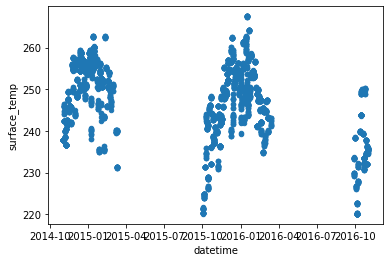

In [11]:
ax1=margretTemperatures.plot.scatter(
    x="datetime",
    y="surface_temp"
)

### Make A Nicer Plot that Compares The Temperature Values From MGT to those you have comptued

In [12]:
#try loading the catalogue from disk since it is large 100 mb, otherwise fetch it from my github page
try:
    catalogue=pd.read_csv("./thermalAndSeismicData/catalogue.csv")
except FileNotFoundError:
    print("loading from github")
    catalogue=pd.read_csv("https://github.com/firstkingofrome/RS_Thermal_final_project/blob/main/thermalAndSeismicData/catalogue.csv?raw=true")
#index catalogue by time stamp
catalogue['pick_time']=pd.to_datetime(catalogue['pick_time'])
catalogue=catalogue.set_index('pick_time')

In [13]:
#gets the nearest (in time) weather data for margret
def get_nearest_weather_data(weather_data,timestamp,return_values=['wind_speed','temp']):
    index=weather_data.index.get_loc(timestamp,"nearest")
    
    return ([weather_data.iloc[index][i] for i in return_values])

In [14]:
#iterate over the thermal temperature data from landsat 8 and add a row 
#I know this isnt efficient but i am too lazy to come up with a better way
for index,row in margretTemperatures.iterrows():
    #get the nearest temperature at this time
    windspeed,temp=get_nearest_weather_data(catalogue,row['datetime'])
    row['weatherstation_temp']=temp
    row['weatherstation_wind']=windspeed
    #update the temperatures dataframe with this information
    margretTemperatures.loc[index]=row
    

/var/folders/jh/mrrrrz5s0q99b_pzrvy_f2nr0000gn/T/ipykernel_5189/2206702503.py:3: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  index=weather_data.index.get_loc(timestamp,"nearest")
/var/folders/jh/mrrrrz5s0q99b_pzrvy_f2nr0000gn/T/ipykernel_5189/2206702503.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  index=weather_data.index.get_loc(timestamp,"nearest")


In [15]:
#correct weather station to be in kelvin
margretTemperatures['weatherstation_temp']=margretTemperatures['weatherstation_temp']+273.15


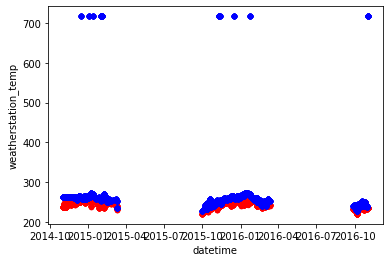

In [16]:
### now make an extremly simple plot comparing estimated from actual ground temperatures

ax1=margretTemperatures.plot.scatter(
    x="datetime",
    y="surface_temp",
    color="red"
)
ax2=margretTemperatures.plot.scatter(
    x="datetime",
    y="weatherstation_temp",
    color="blue",
    ax=ax1
)


In [17]:
#drop values where there is substantial differences
margretTemperatures["T_difference"]=np.abs((margretTemperatures['weatherstation_temp']-margretTemperatures['surface_temp']))
margretTemperatures.drop(margretTemperatures.loc[margretTemperatures['T_difference']>10].index, inplace=True)
#and zero out areas where the windspeed is clearly bull shit
margretTemperatures.loc[margretTemperatures['weatherstation_wind']>100,'weatherstation_wind']=0.0

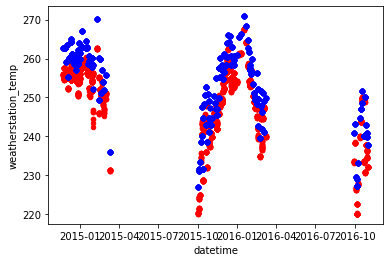

In [18]:
ax1=margretTemperatures.plot.scatter(
    x="datetime",
    y="surface_temp",
    color="red"
)
ax2=margretTemperatures.plot.scatter(
    x="datetime",
    y="weatherstation_temp",
    color="blue",
    ax=ax1
)



In [19]:
### make a chart showing the difference between each for the years that data is availible
### segment time properly
margretTemperatures["year"]=pd.DatetimeIndex(margretTemperatures['datetime']).year
margretTemperatures['month']=pd.DatetimeIndex(margretTemperatures['datetime']).month
margretTemperatures['day']=pd.DatetimeIndex(margretTemperatures['datetime']).day



In [20]:
#show the difference between the computed and actual kinetic temperature values
chart = alt.Chart(margretTemperatures).mark_bar(size=1).encode(
    x='time:T',
    y='T_difference:Q',
    color=alt.Color(
        'T_difference:Q', scale=alt.Scale(scheme='redblue',domain=(0,10))),
    tooltip=[
        alt.Tooltip('time:T', title='Date'),
        alt.Tooltip('T_difference:Q', title='T_difference')
    ]).properties(width=600, height=300).interactive()

if(saveCharts):chart.save(savePlot+"kineticThermalDifferences.html")

In [21]:
#cast all time values as datetime64
#there has to be a better way to do this ...
def castAllTimeAsDatetime64(dataFrame):
    dataFrame=dataFrame.to_dict('records')
    for row in range(len(dataFrame)):
        dataFrame[row]['datetime']=pd.Timestamp(dataFrame[row]['datetime']).to_datetime64()
    return pd.DataFrame.from_records(dataFrame)

#adds empty reocrds to the data frame for plotting purposes
def addEmptyRecords(dataFrame,dates):
    dataFrame=dataFrame.to_dict('records')
    for date in dates:
        newRow=copy.deepcopy(dataFrame[0])
        newRow['T_difference']=0.1
        newRow['datetime']=date
        newRow['weatherstation_wind']=0.0
        dataFrame.append(newRow)
    return pd.DataFrame.from_records(dataFrame)

In [27]:
### make an interval version of this chart comparing T diff vs time
#do this for 2015 only
temps2015=margretTemperatures.loc[margretTemperatures['year']==2015]
#blankdates
blankDates=[pd.Timestamp('2015-03-11 18:55:23.415000').to_datetime64(),pd.Timestamp('2015-09-28 18:55:23.415000').to_datetime64()]
temps2015=addEmptyRecords(temps2015,blankDates)

brush = alt.selection(type='interval', encodings=['x'])

base = alt.Chart(temps2015).mark_area().encode(
    x =alt.X('datetime:T',axis=alt.Axis(format='', title='date')),
    y =alt.Y('T_difference:Q',axis=alt.Axis(format='', title='T_landsat - T_margret k'))
).properties(
    width=600,
    height=200
)

upper = base.encode(
    alt.X('datetime:T', scale=alt.Scale(domain=brush),axis=alt.Axis(title='date'))
)

lower = base.properties(
    height=60
).add_selection(brush)

chart = upper & lower
if(saveCharts):chart.save(savePlot+"2015TDifferenceVsTime.html")
chart


alt.VConcatChart(...)

In [23]:
#rebuild this as a stacked bar chart or soemthin

#make a scatter plot comparing this but also including the wind speed
chart = alt.Chart(temps2015).transform_fold(
    ['T_difference', 'weatherstation_wind'],
).mark_line().encode(
    x='time:T',
    y='value:Q',
    color='key:N'
).interactive()

if(saveCharts):chart.save(savePlot+"2015TDifferenceVsWind.html")
chart



alt.Chart(...)

In [24]:
#based off of this example https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb#scrollTo=p3GeYhrjYBwI

highlight = alt.selection(
    type='single', on='mouseover', fields=['year'], nearest=True)

base = alt.Chart(margretTemperatures).encode(
    x=alt.X('weatherstation_temp:Q', scale=alt.Scale(domain=[220, 280],clamp=True)),
    y=alt.Y('surface_temp:Q', scale=alt.Scale(domain=[220, 280])),
    color=alt.Color('year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('weatherstation_temp:Q', title='Weather Station Temperature'),
        alt.Tooltip('surface_temp:Q', title='Landsat Kinetic Temperature')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

chart = (points + lines).properties(width=600, height=350).interactive()
if(saveCharts):chart.save(savePlot+"surfaceTempVsWeatherStationTemp.html")
chart

alt.LayerChart(...)

In [25]:
#based off of this example https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/time-series-visualization-with-altair/index.ipynb#scrollTo=p3GeYhrjYBwI

highlight = alt.selection(
    type='single', on='mouseover', fields=['year'], nearest=True)

base = alt.Chart(margretTemperatures).encode(
    x=alt.X('weatherstation_wind:Q', scale=alt.Scale(domain=[0, 10],clamp=True)),
    y=alt.Y('T_difference:Q', scale=alt.Scale(domain=[0, 10])),
    color=alt.Color('year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('weatherstation_wind:Q', title='WindSpeed'),
        alt.Tooltip('T_difference:Q', title='Temperature Difference')
    ]).add_selection(highlight)

lines = base.mark_point().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

chart = (points + lines).properties(width=600, height=350).interactive()
if(saveCharts):chart.save(savePlot+"TDiffVsWind.html")
chart

alt.LayerChart(...)